In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=f7801a57a57ce108c4503b0fae9996785754ad912b574d8e0646d74bae2f8db2
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=b6826be5d2e4641045c4511c962ea5fea562dab9f729c42232cb009386cfd2af
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
path_main = '../input/osic-pulmonary-fibrosis-progression/'

In [6]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [7]:
def get_tab(df):
    vector = [(df.Age.values[0] - df.Age.mean()) / df.Age.std()] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [8]:
train.Patient.unique().shape

(176,)

In [9]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

|          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


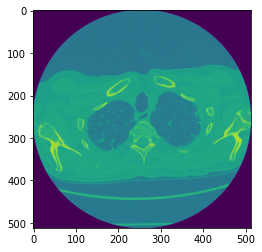

In [10]:
d = pydicom.dcmread(path_main+'/train/'+train.Patient[0]+'/5.dcm')
d = cv2.resize(d.pixel_array/2**8, (512, 512))
plt.imshow(d)

In [11]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [12]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [24]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, GlobalMaxPooling2D,
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    print('x: {}\n'.format(x))
    x = GlobalMaxPooling2D()(x)
    print('x: {}\n'.format(x))
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    print('x: {}\n'.format(x))
    x = Dropout(0.5)(x) 
    print('x: {}\n'.format(x))
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    model.load_weights('../input/effnet-b5-30epochs-1/effnet_30.h5')
    print('inp: {} \n\n base:{} \n\n x: {}\n\n'.format(inp,base,x))
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

x: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 2048), dtype=tf.float32, name=None), name='efficientnet-b5/top_activation/mul:0', description="created by layer 'efficientnet-b5'")

x: KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='global_max_pooling2d_4/Max:0', description="created by layer 'global_max_pooling2d_4'")

x: KerasTensor(type_spec=TensorSpec(shape=(None, 2052), dtype=tf.float32, name=None), name='concatenate_7/concat:0', description="created by layer 'concatenate_7'")

x: KerasTensor(type_spec=TensorSpec(shape=(None, 2052), dtype=tf.float32, name=None), name='dropout_7/Identity:0', description="created by layer 'dropout_7'")

inp: KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name='input_79'), name='input_79', description="created by layer 'input_79'") 
 base:<tensorflow.python.keras.engine.functional.Functional object at 0x7f51967581d0> 
 x: KerasTensor(type_spec=TensorSpec(shape=(None, 1), 

In [16]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 1) 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


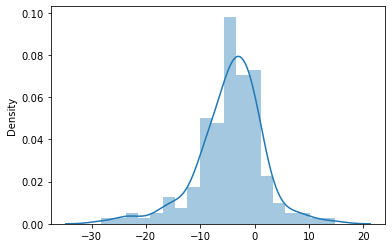

In [17]:
sns.distplot(list(A.values()));

In [ ]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [ ]:
subs = []
for model in models:

    q = 0.5

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)